# Tuning BM25 parameters on the MSMARCO Document dataset

The following shows a principled, data-driven approach to tuning BM25 parameters with a basic query, using the MSMARCO Document dataset. This assumes familiarity with basic query tuning as shown in the "Query Tuning" notebooks.

BM25 contains two parameters `k1` and `b`. Roughly speaking (very roughly), `k1` controls the amount of term saturation (at some point, more terms does not mean more relevant) and `b` controls the importance of document length. A deeper look into these parameters is beyond the scope of this notebook, but our [three part blog series on understanding BM25](https://www.elastic.co/blog/practical-bm25-part-1-how-shards-affect-relevance-scoring-in-elasticsearch) is very useful for that.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_bm25_mrr100
from qopt.optimize import Config, set_bm25_parameters

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.234.93.126:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 30

# default Elasticsearch BM25 params
default_bm25_params = {'k1': 1.2, 'b': 0.75}

# default query params for cross_fields
query_params = {
    'operator': 'OR',
    'minimum_should_match': 50,  # in percent/%
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
}

## Baseline evaluation

For tuning the BM25 parameters, we're going to reuse [the `multi_match` query of type `cross_fields`](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-multi-match-query.html#type-cross-fields) that we saw in the "Query Tuning" notebook. It will search for query terms across the `url`, `title`, and `body` fields, and we'll be attempting to optimize the BM25 parameters that are used in the scoring function for each field. In theory, each field could have it's own BM25 [similarty](https://www.elastic.co/guide/en/elasticsearch/reference/current/index-modules-similarity.html#bm25) and parameters, but we'll leave that as an exercise to the reader.

Since BM25 parameters are actually index settings in Elasticsearch (they are theoretically query parameters, but they are implemented as index settings to be consistent with other similarity modules), we need to make sure to set the parameters before any evaluation step. At optimization time, we'lll do the same process: set the BM25 parameters to try, then run the rank evaluation API on the training query dataset.

In [5]:
%%time

set_bm25_parameters(es, 'msmarco-document', **default_bm25_params)

_ = evaluate_mrr100_dev(es, max_concurrent_searches, 'cross_fields', query_params)

Score: 0.2669
CPU times: user 3.53 s, sys: 954 ms, total: 4.49 s
Wall time: 1min 14s


That's the same baseline that we've seen in the "Query Tuning" notebook, so we know we're setup correctly.

## Optimization

Now we're ready to run the optimization procedure and see if we can improve on that, while holding the default query parameters constant.

We know that there's roughly a standard range for each parameter, so we've hardcoded those. We don't show all the code details here, but you can have a look in the corresponding Python module files for more details. Here's the pertinent details for our parameter space:

* `k1`: `0.5` to `5.0`
* `b`: `0.3` to `1.0`
* number of iterations: `50`
* number of initial points: `10`
* static initial points:
  * Elasticsearch defaults: `k1`: `1.2`, `b`: `0.75`
  * Anserini [1] defaults: `k1`: `0.9`, `b`: `0.4`
  
[1] [anserini](https://github.com/castorini/anserini) is a commonly used tool in academia for research into search systems

In [6]:
%%time

_, best_params, _, metadata = optimize_bm25_mrr100(es, max_concurrent_searches, 'cross_fields', query_params)

Optimizing parameters
 - iteration 2 scored 0.2090 with: {'k1': 0.9, 'b': 0.4}
 - iteration 3 scored 0.2327 with: {'k1': 2.106460400937828, 'b': 0.9814034832854355}
 - iteration 4 scored 0.2348 with: {'k1': 3.2107221791452973, 'b': 0.6303789169373522}
 - iteration 5 scored 0.2250 with: {'k1': 0.832042959138801, 'b': 0.9505828006392114}
 - iteration 6 scored 0.2033 with: {'k1': 2.5844577103580235, 'b': 0.3172574489160101}
 - iteration 7 scored 0.2354 with: {'k1': 1.4603070752661074, 'b': 0.9095877171637401}
 - iteration 8 scored 0.2269 with: {'k1': 3.835769365981418, 'b': 0.5624379914456362}
 - iteration 9 scored 0.2367 with: {'k1': 4.598047785287948, 'b': 0.9240403737699603}
 - iteration 10 scored 0.2194 with: {'k1': 4.705663588307449, 'b': 0.5461322345696533}
 - iteration 11 scored 0.2384 with: {'k1': 4.270664449657518, 'b': 0.8397889874192266}
 - iteration 12 scored 0.2119 with: {'k1': 3.86729056925115, 'b': 0.430001696200928}
 - iteration 13 scored 0.2412 with: {'k1': 3.121740428055

In [7]:
%%time

set_bm25_parameters(es, 'msmarco-document', **best_params)

_ = evaluate_mrr100_dev(es, max_concurrent_searches, 'cross_fields', query_params)

Score: 0.2685
CPU times: user 1.94 s, sys: 488 ms, total: 2.43 s
Wall time: 1min 16s


Pretty good, we see an improvement just from tuning the BM25 parameters. Here's a look at the parameter space, which is easy to plot here since there are just two parameters.

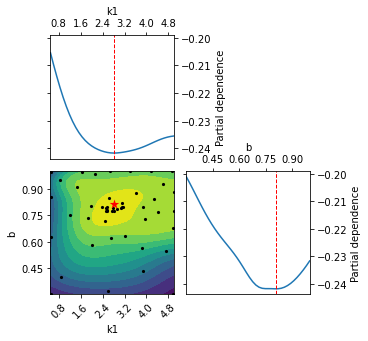

In [8]:
_ = plot_objective(metadata, sample_source='result')

It's good to see smooth curves with just a single optimal point in the parameter space.

Before we wrap up the notebook, it's good to set the BM25 index settings back to the defaults so that anything we run after this notebook on the same index will not be using unexpected parameter values!

In [9]:
set_bm25_parameters(es, 'msmarco-document', **default_bm25_params)

## Conclusion

We've shown a very simple but principled way to tune BM25 parameters `k1` and `b`. We've used a similar approach as when optimizing query parameters. In this case, it was useful to rely on Bayesian optimization since we set a pretty wide range over parameters. Stepping through each 1/10th or 1/100th of each parameter in a grid search would be very time consuming indeed.